# Neural Style Transfer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!rm -rf /content/drive/MyDrive/neural-style-transfer/

In [ ]:
%cd /content/drive/MyDrive/
!git clone https://github.com/egesabanci/neural-style-transfer

/content/drive/MyDrive
fatal: destination path 'neural-style-transfer' already exists and is not an empty directory.


### All Imports

In [ ]:
%cd /content/drive/MyDrive/neural-style-transfer/
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import matplotlib.pyplot as plt
from skimage import io, transform

# rewrite the paths for your own images and base folder
BASE = "/content/drive/MyDrive/neural-style-transfer/"
CONTENT_IMAGE_PATH = os.path.join(BASE, "images", "SirNaeem.jpg")
STYLE_IMAGE_PATH = os.path.join(BASE, "images", "style2.png")

/content/drive/MyDrive/neural-style-transfer


## **Loading Images - I/O**


In [ ]:
def load_image(path: str):
  image = io.imread(path)
  expanded = tf.expand_dims(tf.cast(tf.convert_to_tensor(image),
                                    tf.float32) / 255., axis = 0)

  return expanded

class Constants(object):
  CONTENT_WEIGHT = 2e-5
  STYLE_WEIGHT = 1e-4

CONTENT = load_image(CONTENT_IMAGE_PATH)
STYLE = load_image(STYLE_IMAGE_PATH)
COMBINED = tf.Variable(CONTENT)

### Loss Functions

In [ ]:
class Loss(object):

  @classmethod
  def gram_matrix(cls, arr):
    """Gramian matrix for calculating style loss"""
    x = tf.transpose(arr, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))

    return gram


  @classmethod
  def content_loss(cls, content, generated):
    """1/2 * sum of (generated - original) ** 2"""
    content_loss = tf.reduce_sum(tf.square((generated - content)))

    return content_loss * 5e-1


  @classmethod
  def style_loss(cls, style, generated):
    style_gram = cls.gram_matrix(style)
    generated_gram = cls.gram_matrix(generated)

    style_loss = tf.reduce_mean(tf.square(generated_gram - style_gram))

    return style_loss

### Models

In [ ]:
class FeatureExtractor(object):

  @classmethod
  def custom_model(cls):
    filters = [64, 128, 64, 32]
    layer_names = [f"conv_block_{i}" for i in range(2, 2 + len(filters))]

    input_layer = tf.keras.layers.Input(shape = (256, 256, 3),
                                        name = "input_layer")


    # Keras Conv2D is a 2D Convolution Layer, this layer creates
    # a convolution kernel that is wind with layers input which
    # helps produce a tensor of outputs.
    x = tf.keras.layers.Conv2D(filters = 32,
                               kernel_size = (2, 2),
                               strides = (1, 1),
                               padding = "same",
                               name = "conv_block_1")(input_layer)

    layer_num = len(layer_names) or len(filters)
    activation_layers = list()

    # on every layer we will apply the activation function and  normalization
    for i in range(layer_num):
      if i % 2 == 1 and i != 0:
        x = tf.keras.layers.ReLU(name = f"relu_layer_{i}th_iter")(x)
        x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv2D(filters = filters[i],
                               kernel_size = (3, 3),
                               strides = (1, 1),
                               padding = "same",
                               name = layer_names[i])(x)

      activation_layers.append(x)

    out = tf.keras.layers.Conv2D(filters = 3,
                               kernel_size = (3, 3),
                               strides = (2, 2),
                               padding = "same",
                               name = "conv_block_out")(x)

    activation_layers.append(out)

    model = tf.keras.models.Model(inputs = input_layer,
                                  outputs = activation_layers,
                                  name = "feature_extractor_model")

    return model


  @classmethod
  def vgg_extractor_model(cls):
    vgg_model = tf.keras.applications.VGG19(include_top = False,
                                            weights = "imagenet")

    style_conv_blocks = [f"block{i}_conv1" for i in range(1, 6)]
    content_conv_block = ["block5_conv2"]
    all_activation_layers = style_conv_blocks + content_conv_block

    input_layer = vgg_model.inputs
    output_layers = [vgg_model.get_layer(i).output for i in all_activation_layers]

    model = tf.keras.models.Model(inputs = input_layer,
                                  outputs = output_layers,
                                  name = "vgg19_extractor")

    return model


  @classmethod
  def vgg_with_recurrent(cls):
    input_layer = tf.keras.layers.Input(shape = (256, 256, 3))
    vgg_layer = tf.keras.applications.VGG19(include_top = False,
                                            weights = "imagenet")(input_layer)

    content_activation = tf.keras.layers.ConvLSTM2D(64, (1, 1), (1, 1),
                                                    padding = "same")

    num_layers = 1
    recurrent_layer_names = [f"rnn_conv_{i}" for i in range(1, num_layers)]
    recurrent_layers = list()
    for layer_name in recurrent_layer_names:
      rnn_layer = tf.keras.layers.ConvLSTM2D(64, (1, 1), (1, 1), padding = "same",
                                             name = layer_name)
      recurrent_layers.append(rnn_layer)

    x = input_layer
    model_outputs = list()
    for rnn_layer in recurrent_layers:
      x = tf.expand_dims(x, axis = 0)
      x = rnn_layer(x)
      model_outputs.append(x)

    x = tf.expand_dims(x, axis = 0)
    out = content_activation(x)
    model_outputs.append(out)

    model = tf.keras.models.Model(inputs = input_layer,
                                  outputs = model_outputs,
                                  name = "vgg_19_with_recurrent")

    return model


  @classmethod
  def extract(cls, image_stack, model):
    """Image stack is (3, None, None, 3)
    shaped image data which contains
    content, style and generated images"""
    return model()(image_stack)


  @staticmethod
  def get_layers(features):
    content = features[-1]
    style = features[:-1]

    return content, style

### Training step - calculating loss

In [ ]:
class Train(Loss, FeatureExtractor):

  @classmethod
  def calculate_step_loss(cls, model, content, style, generated):
    tensor = tf.concat([content, style, generated], axis = 0)
    features = cls.extract(image_stack = tensor, model = model)
    content_act, style_act = cls.get_layers(features)

    content_loss = cls.content_loss(content_act[0], content_act[-1])

    style_loss = 0.
    for layer in style_act:
      layer_loss = cls.style_loss(layer[1], layer[-1])
      style_loss += layer_loss

    loss = (content_loss * Constants.CONTENT_WEIGHT) \
           + (style_loss * Constants.STYLE_WEIGHT)

    return loss

### Training Loop

In [ ]:
def train(model, content, style, generated, epochs = 10):
  optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4)
  for epoch in range(epochs):
    # The GradientTape function records the operation for automatic differentiation.
    # The recorded operations if they are executed within this context manager and
    # at least one of their inputs is being watched. The tensors can be manually
    # watched by invoking the watch method on this context manager.
    with tf.GradientTape() as GT:
      loss = Train.calculate_step_loss(model, content, style, generated)

    print(f"EPOCH: {epoch + 1} \nLOSS: {loss}\n" + ("---" * 15))

    gradients = GT.gradient(loss, generated)
    optimizer.apply_gradients([(gradients, generated)])

  return generated

### Main Training Process

##### Classsical Style Transfer Approach with VGG19 Extractor

In [ ]:
styled_img_vgg = train(model = FeatureExtractor.vgg_extractor_model,
                       content = CONTENT,
                       style = STYLE,
                       generated = COMBINED,
                       epochs = 50)

EPOCH: 1 
LOSS: 4212000.5
---------------------------------------------
EPOCH: 2 
LOSS: 4467066.5
---------------------------------------------
EPOCH: 3 
LOSS: 3241183.75
---------------------------------------------
EPOCH: 4 
LOSS: 2442287.75
---------------------------------------------
EPOCH: 5 
LOSS: 1855862.625
---------------------------------------------
EPOCH: 6 
LOSS: 1485619.0
---------------------------------------------
EPOCH: 7 
LOSS: 1140694.5
---------------------------------------------
EPOCH: 8 
LOSS: 938785.125
---------------------------------------------
EPOCH: 9 
LOSS: 756841.5625
---------------------------------------------
EPOCH: 10 
LOSS: 617544.5625
---------------------------------------------
EPOCH: 11 
LOSS: 504367.125
---------------------------------------------
EPOCH: 12 
LOSS: 443853.375
---------------------------------------------
EPOCH: 13 
LOSS: 415457.75
---------------------------------------------
EPOCH: 14 
LOSS: 380383.53125
-------------------

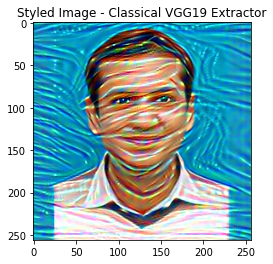

In [ ]:
plt.title("Styled Image - Classical VGG19 Extractor")
plt.imshow(tf.squeeze(styled_img_vgg, axis = 0))
plt.show()

##### Style Transfer with Recurrent Convolution Layers (ConvLSTM2D)

In [ ]:
styled_img_rnn = train(model = FeatureExtractor.vgg_with_recurrent,
                   content = CONTENT,
                   style = STYLE,
                   generated = COMBINED,
                   epochs = 30)

EPOCH: 1 
LOSS: 0.00020213534298818558
---------------------------------------------
EPOCH: 2 
LOSS: 0.0001829618850024417
---------------------------------------------
EPOCH: 3 
LOSS: 0.00020252703689038754
---------------------------------------------
EPOCH: 4 
LOSS: 0.0002126996696460992
---------------------------------------------
EPOCH: 5 
LOSS: 0.00019416290160734206
---------------------------------------------
EPOCH: 6 
LOSS: 0.000212603627005592
---------------------------------------------
EPOCH: 7 
LOSS: 0.00017450367158744484
---------------------------------------------
EPOCH: 8 
LOSS: 0.00019205811258871108
---------------------------------------------
EPOCH: 9 
LOSS: 0.00019838266598526388
---------------------------------------------
EPOCH: 10 
LOSS: 0.00015748338773846626
---------------------------------------------
EPOCH: 11 
LOSS: 0.0001719718857202679
---------------------------------------------
EPOCH: 12 
LOSS: 0.00017606306937523186
----------------------------

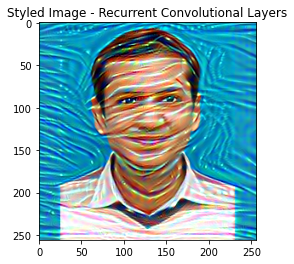

In [ ]:
plt.title("Styled Image - Recurrent Convolutional Layers")
plt.imshow(tf.squeeze(styled_img_rnn, axis = 0))
plt.show()

##### Style Transfer with custom convolutional layers

In [ ]:

styled_img_custom = train(model = FeatureExtractor.custom_model,
                          content = CONTENT,
                          style = STYLE,
                          generated = COMBINED,
                          epochs = 30)


EPOCH: 1 
LOSS: 966.78515625
---------------------------------------------
EPOCH: 2 
LOSS: 693.7907104492188
---------------------------------------------
EPOCH: 3 
LOSS: 238.69970703125
---------------------------------------------
EPOCH: 4 
LOSS: 414.4868469238281
---------------------------------------------
EPOCH: 5 
LOSS: 1021.9475708007812
---------------------------------------------
EPOCH: 6 
LOSS: 749.6253051757812
---------------------------------------------
EPOCH: 7 
LOSS: 299.9745788574219
---------------------------------------------
EPOCH: 8 
LOSS: 519.8392944335938
---------------------------------------------
EPOCH: 9 
LOSS: 526.1056518554688
---------------------------------------------
EPOCH: 10 
LOSS: 464.0642395019531
---------------------------------------------
EPOCH: 11 
LOSS: 657.4693603515625
---------------------------------------------
EPOCH: 12 
LOSS: 452.36212158203125
---------------------------------------------
EPOCH: 13 
LOSS: 160.36936950683594
------

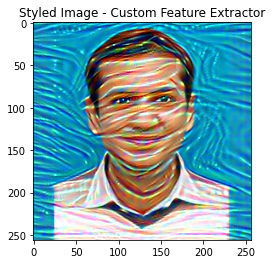

In [ ]:

plt.title("Styled Image - Custom Feature Extractor")
plt.imshow(tf.squeeze(styled_img_custom, axis = 0))
plt.show()
